### HMM Model Selection
 * Generate data from a 3-state HMM
 * Attempt to train a model over various states, and select the optimal model
 * Use Bayesian Information Criterion:  http://www.columbia.edu/~on2110/Papers/Ebbes_Netzer_2018.pdf
 

In [1]:
import sys
import collections

In [2]:
sys.path.insert(0, "..")

In [3]:
from hmm import CategoricalHMM, GaussianHMM, PoissonHMM, model_selection, plots
from hmm import HMMSearch
import sklearn.preprocessing
import sklearn.utils
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.metrics
import numpy as np
import pandas as pd
import numpy.random
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
sns.set()

## Multinomial

### Generate Training Data

In [6]:
numpy.random.rand()

0.9552308387039297

In [7]:
pi_1 = [ .5, .3, .2]
A_1 = [ [0.1, 0.1, 0.8], 
       [0.0, 0.5, 0.5],
      [0.6, 0.2, 0.2]
      ]
B_1 = [
    [0.1, 0.2, 0.7],
    [0.1, 0.7, 0.2],
    [0.7, 0.2, 0.1]
]

In [8]:
hmm1 = CategoricalHMM.CategoricalHMM(
    init_pi=False,
    init_B=False,
    init_A=False,
    implementation="cython",
    random_state=1
)
hmm1.pi_ = pi_1
hmm1.A_ = A_1
hmm1.B_ = B_1

In [9]:
observations1, hiddens1 = hmm1.sample(n_samples=1000, length=100)

In [10]:
print(np.sum(hmm1.predict_log_proba(observations1)))

-106016.27664795752


In [11]:
learned = CategoricalHMM.CategoricalHMM(n_components=3, n_iterations=100, tol=1e-6, n_inits=4)


In [12]:
%time learned.fit(observations1)

CPU times: user 20.5 ms, sys: 32.6 ms, total: 53.1 ms
Wall time: 6.02 s


CategoricalHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
        init_B=True, init_pi=True, n_components=3, n_features=None,
        n_inits=4, n_iterations=100, n_jobs=-1, random_state=None,
        smoothing=None, tol=1e-06, verbose=0)

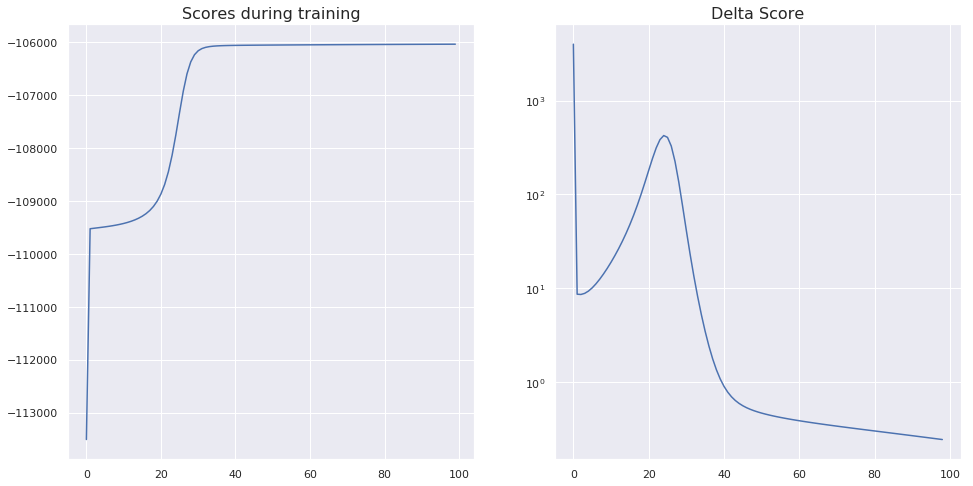

In [13]:
_ = plots.learning_plot(learned.loglikelihoods_)

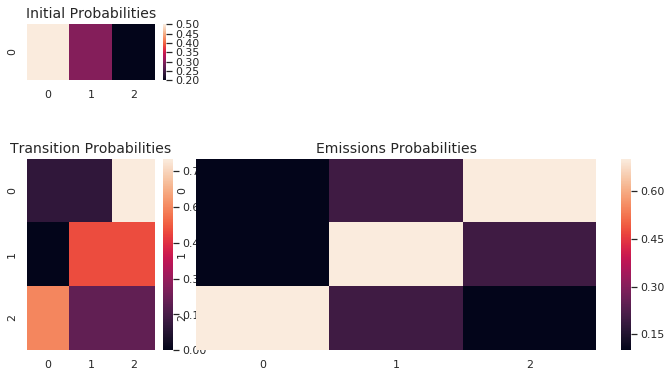

In [14]:
_ = plots.hinton_diagram(hmm1.pi_, hmm1.A_, hmm1.B_)

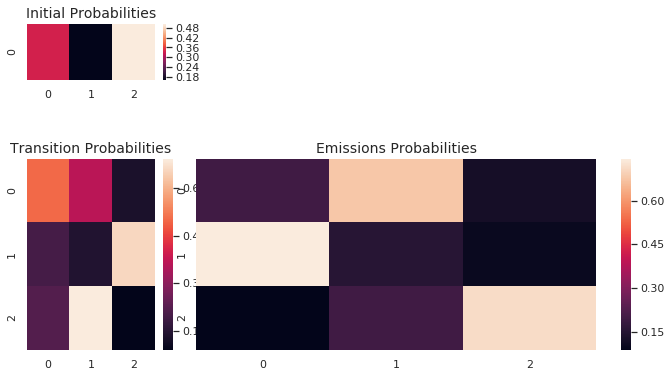

In [15]:
_ = plots.hinton_diagram(learned.pi_, learned.A_, learned.B_)

In [16]:
learned.predict_log_proba(observations1).sum()

-106038.49332140427

In [17]:
hmm1.predict_log_proba(observations1).sum()

-106016.27664795754

### Grid Search over training data for optimal model
 * Will train 4 models at each n_components, keeping the model with lowest LL
 * Then use BIC to select the best (can also use AIC, but literature seems to prefer AIC)

In [18]:
searcher = HMMSearch.HMMSearch(
    CategoricalHMM.CategoricalHMM(n_iterations=100, tol=1e-4),
    n_components=[1,2,3,4,5,6,7,8,9],
    n_inits=4,
    verbose=True,
    criterion="bic",
    n_jobs=3
)

In [19]:
%time searcher.fit(observations1)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  1.2min finished


Not Exchanging at 1: -109.53468467852028 for -109.53468467852028
Not Exchanging at 1: -109.53468467852028 for -109.53468467852028
Not Exchanging at 1: -109.53468467852028 for -109.53468467852028
Not Exchanging at 2: -106.46820901891702 for -106.46908440280356
Not Exchanging at 2: -106.46820901891702 for -109.27066943474777
Not Exchanging at 2: -106.46820901891702 for -109.2730104062613
Not Exchanging at 3: -106.0510713491943 for -106.39710538408818
Exchanging at 3: -106.0510713491943 for -106.03319813463085
Exchanging at 3: -106.0510713491943 for -106.02441653081065
Not Exchanging at 4: -106.03465810143089 for -106.04239933132351
Not Exchanging at 4: -106.03465810143089 for -106.03881483336073
Not Exchanging at 4: -106.03465810143089 for -106.23681790154855
Exchanging at 5: -106.03183787328442 for -106.02759529801126
Not Exchanging at 5: -106.03183787328442 for -106.05880901155028
Exchanging at 5: -106.03183787328442 for -106.01674904979396
Not Exchanging at 6: -106.02110402813351 for 

HMMSearch(criterion='bic',
     estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
        init_B=True, init_pi=True, n_components=1, n_features=None,
        n_inits=1, n_iterations=100, n_jobs=-1, random_state=None,
        smoothing=None, tol=0.0001, verbose=0),
     n_components=[1, 2, 3, 4, 5, 6, 7, 8, 9], n_inits=4, n_jobs=3,
     random_state=None, verbose=True)

In [20]:
scores = pd.DataFrame(searcher.scores_).T

In [21]:
scores

aic            bic           caic          score
1  219073.369357  219092.395208  219094.395208 -109534.684679
2  212950.418038  213017.008516  213024.008516 -106468.209019
3  212076.833062  212210.014018  212224.014018 -106024.416531
4  212115.316203  212334.113489  212357.113489 -106034.658101
5  212101.498100  212424.937565  212458.937565 -106016.749050
6  212136.208056  212583.315553  212630.315553 -106021.104028
7  212163.150982  212752.952360  212814.952360 -106019.575491
8  212204.043537  212955.564649  213034.564649 -106023.021768
9  212237.599905  213169.866601  213267.866601 -106020.799953

In [22]:
scores[["aic", "bic"]].idxmin()

aic    3
bic    3
dtype: int64

In [23]:
scores[["score"]].idxmax()

score    5
dtype: int64

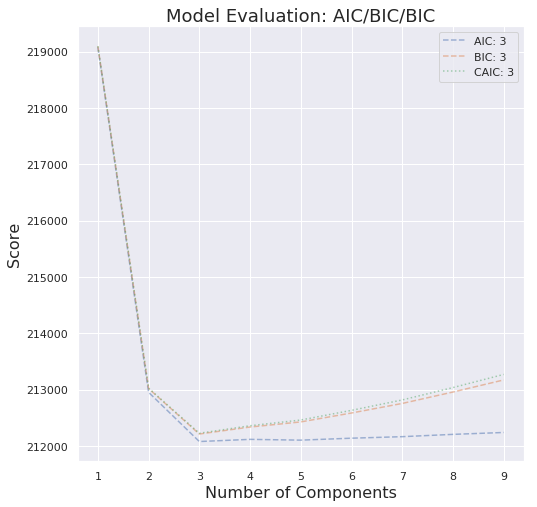

In [24]:
_ = plots.plot_bic_aic(searcher.scores_)

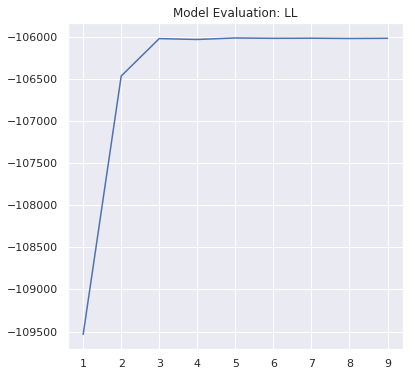

In [25]:
ax = scores["score"].plot(figsize=(6,6))
_ = ax.set_title("Model Evaluation: LL")

In [26]:
for n_components, model in searcher.bests_.items():
    print(n_components, model.loglikelihoods_[-2:], model.num_free_params())

1 [-109534.68467852028, -109534.68467852028] 2
2 [-106468.6700806416, -106468.43699198426] 7
3 [-106025.02255040975, -106024.71389617948] 14
4 [-106034.94540293573, -106034.79927564636] 23
5 [-106016.98601619201, -106016.86527362259] 34
6 [-106021.46702851102, -106021.28403503275] 47
7 [-106019.9018766626, -106019.73738117449] 62
8 [-106023.43461192318, -106023.22648008715] 79
9 [-106021.07413415062, -106020.9356901093] 98


In [27]:
searcher.best_model_.pi_

array([0.18637747, 0.38002648, 0.43359605])

In [28]:
searcher.best_model_.A_

array([[0.15910168, 0.27729986, 0.56359847],
       [0.47192487, 0.48375852, 0.04431662],
       [0.75222309, 0.15476811, 0.0930088 ]])

In [29]:
searcher.best_model_.B_

array([[0.73509454, 0.17534025, 0.08956521],
       [0.11006011, 0.67925182, 0.21068807],
       [0.11049632, 0.14748241, 0.74202127]])

## Gaussian Example

In [30]:
pig_1 = [ .5, .3, .2]
Ag_1 = [ [0.6, 0.3, 0.1], 
       [0.4, 0.4, 0.2],
       [0.1, 0.3, 0.6]
      ]
meansg_1 = [-4, 0, 4]
variancesg_1 = [2, 2, 4]


In [31]:
gauss1 = GaussianHMM.GaussianHMM(
    n_iterations=0,
    init_pi=False,
    init_A=False,
    init_means=False,
    init_variances=False,
    implementation="python",
)
gauss1.pi_ = pig_1
gauss1.A_ = Ag_1
gauss1.means_ = meansg_1
gauss1.variances_ = variancesg_1

In [32]:
a_observations, a_hiddens = gauss1.sample(n_samples=1000, length=100)

In [33]:
learned_gaussian = GaussianHMM.GaussianHMM(n_components=3, n_iterations=100, tol=1e-6, n_inits=4, verbose=20)

In [34]:
%time learned_gaussian.fit(a_observations)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.2s remaining:    8.2s


CPU times: user 3.8 ms, sys: 16 ms, total: 19.8 ms
Wall time: 9.46 s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.5s finished


GaussianHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
      init_means=True, init_pi=True, init_variances=True, n_components=3,
      n_inits=4, n_iterations=100, n_jobs=-1, random_state=None, tol=1e-06,
      variance_regularization=1e-06, verbose=20)

In [35]:
learned_gaussian

GaussianHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
      init_means=True, init_pi=True, init_variances=True, n_components=3,
      n_inits=4, n_iterations=100, n_jobs=-1, random_state=None, tol=1e-06,
      variance_regularization=1e-06, verbose=20)

In [36]:

print(learned_gaussian.pi_)

[0.50473488 0.27187985 0.22338527]


In [37]:

print(learned_gaussian.A_)

[[0.6080844  0.29184609 0.10006951]
 [0.39366405 0.40796435 0.1983716 ]
 [0.10049915 0.29643245 0.6030684 ]]


In [38]:

print(learned_gaussian.means_)

[-3.98158026  0.00901614  3.99620524]


In [39]:

print(learned_gaussian.variances_)

[2.04687718 2.03181969 3.99303287]


In [40]:
searcher_gaussian = HMMSearch.HMMSearch(
    GaussianHMM.GaussianHMM(n_iterations=100, tol=1e-4),
    n_components=[1,2,3,4,5,6,7,8,9],
    n_inits=4,
    verbose=True,
    criterion="bic",
    n_jobs=3
)

In [41]:
%time searcher_gaussian.fit(a_observations)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  2.6min finished


Not Exchanging at 1: -269.7845819657766 for -269.7845819657766
Not Exchanging at 1: -269.7845819657766 for -269.7845819657766
Not Exchanging at 1: -269.7845819657766 for -269.7845819657766
Exchanging at 2: -257.75007714767065 for -257.75007708870083
Exchanging at 2: -257.75007714767065 for -257.7500770894453
Exchanging at 2: -257.75007714767065 for -257.75007708894884
Not Exchanging at 3: -254.19704430395242 for -254.1970443654984
Not Exchanging at 3: -254.19704430395242 for -254.19704434284924
Exchanging at 3: -254.19704430395242 for -254.19704422865857
Not Exchanging at 4: -254.2105979746745 for -254.2107830582416
Not Exchanging at 4: -254.2105979746745 for -254.21063583944843
Not Exchanging at 4: -254.2105979746745 for -254.21073175596038
Exchanging at 5: -254.2203770318055 for -254.21957495552942
Exchanging at 5: -254.2203770318055 for -254.21991026055983
Exchanging at 5: -254.2203770318055 for -254.21986688374355
Not Exchanging at 6: -254.2173091755331 for -254.21832967943126
Not 

HMMSearch(criterion='bic',
     estimator=GaussianHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
      init_means=True, init_pi=True, init_variances=True, n_components=1,
      n_inits=1, n_iterations=100, n_jobs=-1, random_state=None,
      tol=0.0001, variance_regularization=1e-06, verbose=0),
     n_components=[1, 2, 3, 4, 5, 6, 7, 8, 9], n_inits=4, n_jobs=3,
     random_state=None, verbose=True)

In [42]:
print(pig_1)
print(searcher_gaussian.best_model_.pi_)

[0.5, 0.3, 0.2]
[0.50473245 0.22338533 0.27188223]


In [43]:
print(Ag_1)
print(searcher_gaussian.best_model_.A_)

[[0.6, 0.3, 0.1], [0.4, 0.4, 0.2], [0.1, 0.3, 0.6]]
[[0.60808228 0.10006919 0.29184853]
 [0.10049776 0.60306937 0.29643287]
 [0.39366251 0.19837087 0.40796662]]


In [44]:
print(meansg_1)
print(searcher_gaussian.best_model_.means_)

[-4, 0, 4]
[-3.98159127  3.99620134  0.00900296]


In [45]:
print(variancesg_1)
print(searcher_gaussian.best_model_.variances_)

[2, 2, 4]
[2.04686065 3.9930449  2.031848  ]


In [46]:
searcher_gaussian.scores_

{1: {'bic': 539592.1897824832,
  'caic': 539594.1897824832,
  'aic': 539573.1639315533,
  'score': -269784.5819657766},
 2: {'bic': 515580.74465615244,
  'caic': 515587.74465615244,
  'aic': 515514.15417789767,
  'score': -257750.07708894883},
 3: {'bic': 508555.26941382675,
  'caic': 508569.26941382675,
  'aic': 508422.08845731715,
  'score': -254197.04422865857},
 4: {'bic': 508685.9932350433,
  'caic': 508708.9932350433,
  'aic': 508467.19594934897,
  'score': -254210.59797467449},
 5: {'bic': 508831.1732332961,
  'caic': 508865.1732332961,
  'aic': 508507.7337674871,
  'score': -254219.86688374355},
 6: {'bic': 508975.7258479198,
  'caic': 509022.7258479198,
  'aic': 508528.6183510662,
  'score': -254217.3091755331},
 7: {'bic': 509136.1223478759,
  'caic': 509198.1223478759,
  'aic': 508546.3209690477,
  'score': -254211.16048452386},
 8: {'bic': 509344.65839122667,
  'caic': 509423.65839122667,
  'aic': 508593.137279494,
  'score': -254217.568639747},
 9: {'bic': 509550.661763895

In [47]:
scores_gaussian = pd.DataFrame(searcher_gaussian.scores_).T

In [48]:
scores_gaussian

aic            bic           caic          score
1  539573.163932  539592.189782  539594.189782 -269784.581966
2  515514.154178  515580.744656  515587.744656 -257750.077089
3  508422.088457  508555.269414  508569.269414 -254197.044229
4  508467.195949  508685.993235  508708.993235 -254210.597975
5  508507.733767  508831.173233  508865.173233 -254219.866884
6  508528.618351  508975.725848  509022.725848 -254217.309176
7  508546.320969  509136.122348  509198.122348 -254211.160485
8  508593.137279  509344.658391  509423.658391 -254217.568640
9  508618.395068  509550.661764  509648.661764 -254211.197534

In [49]:
scores_gaussian[["aic", "bic"]].idxmin()

aic    3
bic    3
dtype: int64

In [50]:
scores_gaussian[["score"]].idxmax()

score    3
dtype: int64

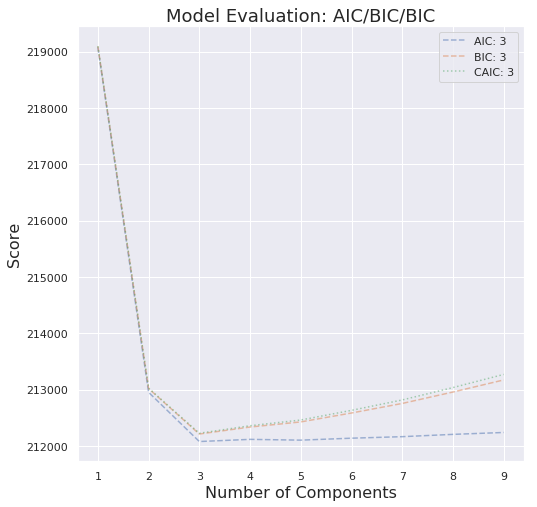

In [51]:
_ = plots.plot_bic_aic(searcher.scores_)

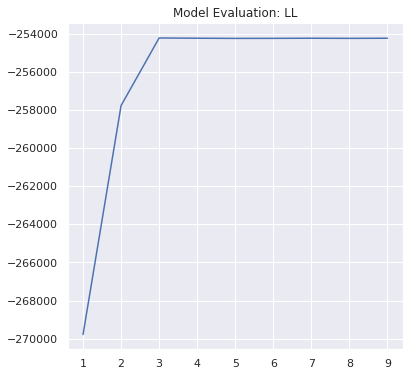

In [52]:
ax =scores_gaussian["score"].plot(figsize=(6,6))
_ = ax.set_title("Model Evaluation: LL")

In [53]:
print("N Delta LL\tK")
for n_components, model in searcher_gaussian.bests_.items():
    print("{}\t{:.3f}\t{}".format(n_components, model.loglikelihoods_[-2] - model.loglikelihoods_[-1], model.num_free_params()))

N Delta LL	K
1	0.000	2
2	-0.000	7
3	-0.000	14
4	-0.089	23
5	-0.175	34
6	-0.266	47
7	-0.205	62
8	-0.280	79
9	-0.198	98


In [54]:
sample_observations, sample_hiddens = gauss1.sample(1, 1000)

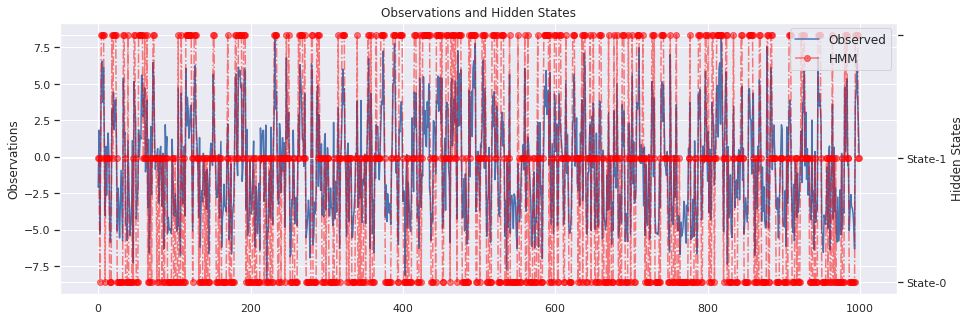

In [55]:
_ = plots.plot_hmm_states(sample_observations.ravel(), sample_hiddens.ravel())

### Poisson...

In [56]:
pip_1 = [ .6, .1, .1, .1]
Ap_1 = [ [0.5, 0.3, 0.1, .1], 
       [0.3, 0.4, 0.2, .1],
       [0.1, 0.3, 0.5, .1],
        [0.1, 0.3, 0.1, .5],
      ]
meansp_1 = [5, 8, 11, 15]


In [57]:
poiss1 = PoissonHMM.PoissonHMM(
    n_iterations=0,
    init_pi=False,
    init_A=False,
    init_means=False,
    implementation="python",
)
poiss1.pi_ = pip_1
poiss1.A_ = Ap_1
poiss1.means_ = meansp_1


In [58]:
p_observations, p_hiddens = poiss1.sample(n_samples=500, length=100)

In [59]:
poisson_selector = HMMSearch.HMMSearch(
    PoissonHMM.PoissonHMM(n_iterations=500, tol=1e-4),
    n_components=[1,2,3,4,5,6,7,8,9],
    n_inits=4,
    verbose=True,
    criterion="bic",
    n_jobs=4
)

In [60]:
%time poisson_selector.fit(p_observations)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  3.7min finished


Not Exchanging at 1: -310.19113146752585 for -310.19113146752585
Not Exchanging at 1: -310.19113146752585 for -310.19113146752585
Not Exchanging at 1: -310.19113146752585 for -310.19113146752585
Exchanging at 2: -285.18746325966123 for -285.1874632375615
Not Exchanging at 2: -285.18746325966123 for -285.1874632899252
Not Exchanging at 2: -285.18746325966123 for -285.1874632933104
Not Exchanging at 3: -283.98128464970756 for -283.9812846593479
Not Exchanging at 3: -283.98128464970756 for -283.9812846841449
Not Exchanging at 3: -283.98128464970756 for -283.9812846834299
Exchanging at 4: -283.95886916831927 for -283.9431497822869
Exchanging at 4: -283.95886916831927 for -283.93858559071134
Exchanging at 4: -283.95886916831927 for -283.9394708336516
Exchanging at 5: -283.94828875036677 for -283.93183413552964
Exchanging at 5: -283.94828875036677 for -283.9335667543374
Exchanging at 5: -283.94828875036677 for -283.9344132254496
Exchanging at 6: -283.9376453612434 for -283.9305446959543
Exch

HMMSearch(criterion='bic',
     estimator=PoissonHMM(allowed_to_use_log=True, implementation='scaling', init_A=True,
      init_means=True, init_pi=True, n_components=1, n_inits=1,
      n_iterations=500, n_jobs=-1, random_state=None, tol=0.0001,
      verbose=0),
     n_components=[1, 2, 3, 4, 5, 6, 7, 8, 9], n_inits=4, n_jobs=4,
     random_state=None, verbose=True)

In [61]:
poisson_selector.bests_[4].loglikelihoods_[-10:]

[-141969.80340841418,
 -141969.796415183,
 -141969.78946603314,
 -141969.78256059918,
 -141969.77569852024,
 -141969.76887943968,
 -141969.76210300514,
 -141969.75536886847,
 -141969.74867668567,
 -141969.74202611682]

In [62]:
poisson_selector.best_model_.loglikelihoods_[-10:]

[-141990.6434244074,
 -141990.64329727314,
 -141990.6431743,
 -141990.64305535157,
 -141990.64294029598,
 -141990.64282900566,
 -141990.64272135717,
 -141990.64261723132,
 -141990.6425165126,
 -141990.6424190894]

In [63]:
print(pip_1)
print(poisson_selector.best_model_.pi_)

[0.6, 0.1, 0.1, 0.1]
[0.73944404 0.14713769 0.11341827]


In [64]:
print(Ap_1)
print(poisson_selector.best_model_.A_)

[[0.5, 0.3, 0.1, 0.1], [0.3, 0.4, 0.2, 0.1], [0.1, 0.3, 0.5, 0.1], [0.1, 0.3, 0.1, 0.5]]
[[0.5803128  0.11293442 0.30675278]
 [0.11814289 0.48073915 0.40111796]
 [0.25097093 0.15021281 0.59881626]]


In [65]:
print(meansp_1)
print(poisson_selector.best_model_.means_)

[5, 8, 11, 15]
[ 5.17836076 14.69295948  9.14709924]


In [66]:
scores_poisson = pd.DataFrame(poisson_selector.scores_).T

In [67]:
print(scores_poisson[["aic", "bic"]].idxmin())
scores_poisson[["bic", "aic"]]

aic    4
bic    3
dtype: int64


bic            aic
1  310201.951246  310193.131468
2  285241.562129  285197.463238
3  284100.302211  284003.284650
4  284145.046621  283977.470834
5  284248.186796  283992.413225
6  284378.205053  284016.594144
7  284528.575790  284043.487984
8  284695.076314  284068.872056
9  284893.324589  284108.364322

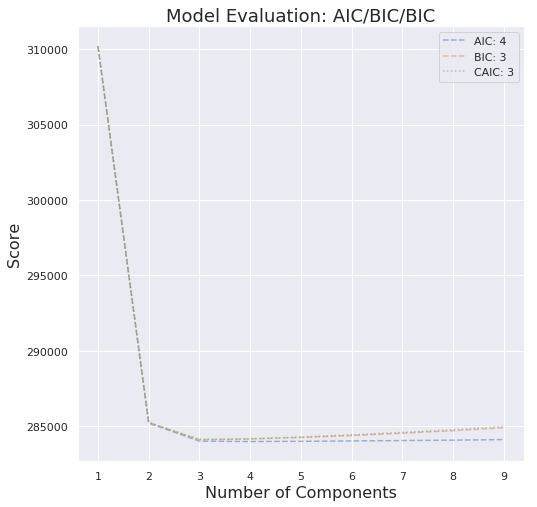

In [68]:
_ = model_selection.plot_bic_aic(poisson_selector.scores_)

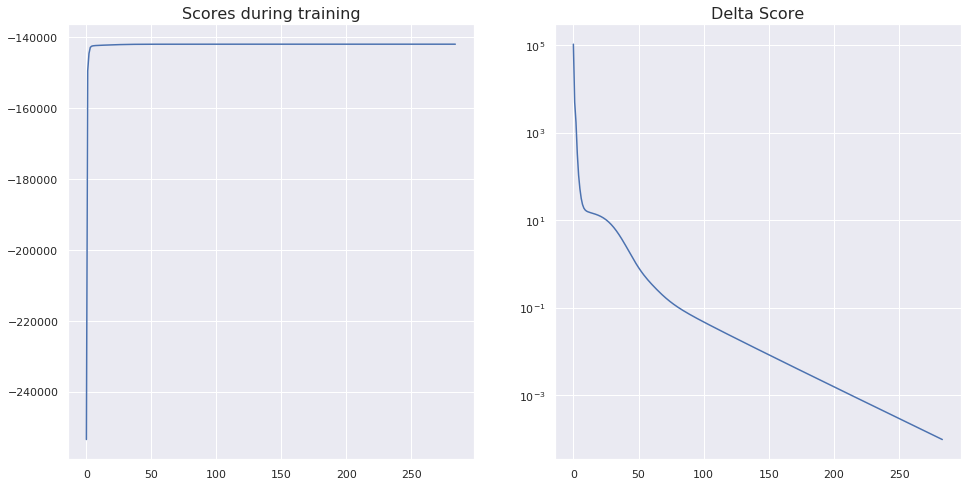

In [69]:
_ = plots.learning_plot(poisson_selector.bests_[3].loglikelihoods_)

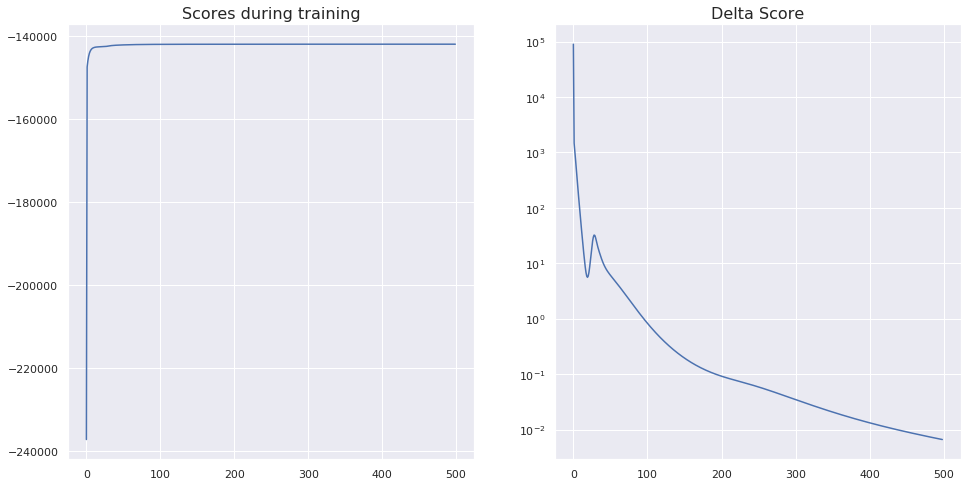

In [70]:
_ = plots.learning_plot(poisson_selector.bests_[4].loglikelihoods_)

In [71]:
poisson_selector.best_model_.means_


array([ 5.17836076, 14.69295948,  9.14709924])

In [72]:
pd.DataFrame(poisson_selector.best_model_.A_)


0         1         2
0  0.580313  0.112934  0.306753
1  0.118143  0.480739  0.401118
2  0.250971  0.150213  0.598816

In [73]:
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

def poisson_hinton_diagram(pi, A, means, vmin=None, vmax=None, b_vals=None, infer_hidden=True):
    """
    Show the initial state probabilities, the transition probabilities as heatmaps, and draw the emission distributions.
    """
    num_states = A.shape[0]

    f = plt.figure(figsize=(4*(num_states), 2*num_states))
    grid = gs.GridSpec(2+ num_states, num_states*4)
    fontsize = 14
    ax = f.add_subplot(grid[:1, :num_states])
    sns.heatmap(pi[None, :], ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title("Initial Probabilities", size=fontsize)
    ax = f.add_subplot(grid[2:num_states+2, :num_states])
    sns.heatmap(A, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title("Transition Probabilities", size=fontsize)
    ax = f.add_subplot(grid[2:num_states+2, num_states:])

    for i in range(num_states):
        keep = True
        if infer_hidden:
            if np.all(np.abs(A[i] - A[i][0]) < 1e-4):
                keep = False
        if keep:
            s_min = means[i] - 10 * means[i]
            s_max = means[i] + 10 * means[i]
            xx = np.arange(max(0, int(s_min)), int(s_max))
            norm = scipy.stats.poisson(means[i])
            yy = norm.pmf(xx)
            keep = yy > .01
            ax.bar(xx[keep], yy[keep], label="State: {}".format(i), alpha=.5)
    ax.set_title("Emissions Probabilities: Poisson", size=fontsize)
    ax.legend(loc="best")
    f.tight_layout()
    return f

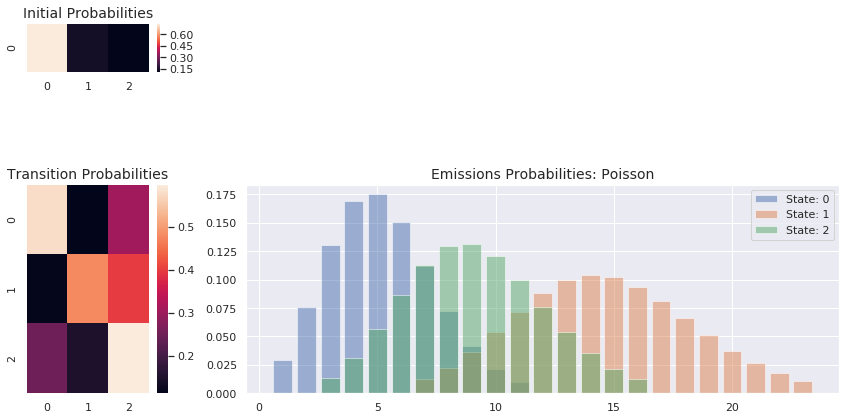

In [74]:
best = poisson_selector.best_model_
_ = poisson_hinton_diagram(
    best.pi_,
    best.A_,
    best.means_
)

### AIC/BIC 

Defined in an R package here:
 * https://rdrr.io/cran/HMMpa/man/AIC_HMM.html
 * Perhaps also grab the accompanying book
 
 
 ```
    size : length of the time-series of observations x (also T).
    m 	 : number of states in the Markov chain of the model.
    k  	 : single numeric value representing the number of parameters of the underlying distribution of the observation process (e.g. k=2 for the normal distribution (mean and standard deviation)).
    logL : logarithmized likelihood of the model

 For a discrete-time hidden Markov model, AIC and BIC are as follows (MacDonald & Zucchini (2009, Paragraph 6.1 and A.2.3)):

AIC = -2 logL + 2p

BIC = -2 logL + p log(T),

where T indicates the length/size of the observation time-series and p denotes the number of independent parameters of the model. In case of a HMM as provided by this package, where k and m are defined as in the arguments above, p can be calculated as follows:

p = m^2 + km - 1.
```